In [1]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
plt.style.use('ggplot')
data = pd.read_csv('bg_master_1.csv')
# data.head(10)
# data.columns


In [2]:
# data.hist(figsize=(18,10) );
data['ENTRIES'][321] = (data.iloc[320].ENTRIES + data.iloc[322].ENTRIES) // 2
data['ENTRIES'][173] = (data.iloc[172].ENTRIES + data.iloc[174].ENTRIES) // 2
data['ENTRIES'][180] = (data.iloc[179].ENTRIES + data.iloc[181].ENTRIES) // 2
data['ENTRIES'][211] = (data.iloc[204].ENTRIES + data.iloc[218].ENTRIES) // 2 # Saturday
data['ENTRIES'][212] = (data.iloc[205].ENTRIES + data.iloc[219].ENTRIES) // 2
data['ENTRIES'][323] = (data['ENTRIES'][316] + data['ENTRIES'][330])// 2#data.loc[316].ENTRIES # Saturday
data['ENTRIES'][324] = (data['ENTRIES'][317] + data['ENTRIES'][331]) // 2
# consider refactoring to use .loc to avoid warnings 
# consider generalizing into helper function "turnstile_clean()"

def is_weekend(date):
    if date.weekday() >= 5:
        return 1
    else: 
        return 0 
    
data['DATE2'] = pd.to_datetime(data.DATE2)
data['is_weekend'] = data.apply(lambda r: is_weekend(r.DATE2), axis=1)
wkend_entries = data[data.is_weekend == 1]
weekday_entries = data[data.is_weekend == 0]
features = ['PRCP','SNOW','SNWD','TMAX','TMIN']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ip

In [3]:
def feature_plots_with_graphs(df):
    results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ]]
    for feature in features: 
        f = 'ENTRIES~' + feature
        print('\n', "Subway Weekend - Regression Analysis and Diagnostics for formula: ",f)
        print("--------------------------------------------------------------------------------------")
        model = ols(formula=f, data=df).fit()
        df_min_max = pd.DataFrame({feature: [df[feature].min(), df[feature].max()]})
        preds = model.predict(df_min_max)
        df.plot(kind='scatter', x=feature, y='ENTRIES')
        plt.plot(df_min_max, preds, c='red', linewidth=2)
        plt.show()
        fig = plt.figure(figsize=(15,8))
        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True,   )
        plt.show()
        results.append([feature, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0] ])    
    return results

def feature_results_summary(df):
    results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ]]
    for feature in features: 
        f = 'ENTRIES~' + feature
        model = ols(formula=f, data=df).fit()
        df_min_max = pd.DataFrame({feature: [df[feature].min(), df[feature].max()]})
        preds = model.predict(df_min_max)
        results.append([feature, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0] ])    
    return results

In [4]:
weekend_results = pd.DataFrame(feature_results_summary(wkend_entries))
weekend_results

,0,1,2,3,4,5
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,PRCP,0.0537471,8722.7,-1196.74,0.0178827,3.29887
2,SNOW,0.00511428,8489.77,235.885,0.470655,2.28656
3,SNWD,0.0114773,8563.85,-225.663,0.279052,1.80008
4,TMAX,0.111539,6261.62,36.7602,0.000530711,3.19333
5,TMIN,0.0641931,7062.96,30.2564,0.00945711,2.61552


In [5]:
weekday_results = pd.DataFrame(feature_results_summary(weekday_entries))
weekday_results

,0,1,2,3,4,5
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,PRCP,0.00982815,28921.1,-1213.98,0.110074,1855.46
2,SNOW,0.0633981,28894.5,-1200.91,3.87596e-05,2157.2
3,SNWD,0.00183272,28763,-204.191,0.491064,1760.08
4,TMAX,0.0367809,25845.9,45.9597,0.00185555,1476.89
5,TMIN,0.0289766,26599.5,43.0837,0.00583306,1492.22


In [6]:
def categorize_rain(data):
    if data['PRCP'] < 0.01:
        return 0
    if data['PRCP'] >= 0.01 and data['PRCP'] < 0.08:
        return 1
    elif data['PRCP'] >= 0.08 and data['PRCP'] < 0.25:
        return 2
    elif data['PRCP'] >= 0.25 and data['PRCP'] < 0.6575:
        return 3
    elif data['PRCP'] >= 0.6575 and data['PRCP'] <3:
        return 4

data['RAIN'] = data.apply(lambda r: categorize_rain(r), axis = 1)
rain_types = data[data.RAIN > 0]
rain_types.head()

,Unnamed: 0,DATE2,ENTRIES,EXITS,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,RAIN
4,4,2017-12-05,32625,27968,0.75,0.0,0.0,61.0,50.0,0,4
8,8,2017-12-09,9534,9433,0.46,4.6,0.0,35.0,30.0,1,3
13,13,2017-12-14,31894,27021,0.09,1.2,1.2,32.0,22.0,0,2
14,14,2017-12-15,28913,25307,0.11,1.2,1.2,28.0,20.0,0,2
17,17,2017-12-18,30970,26463,0.02,0.0,0.0,47.0,34.0,0,1


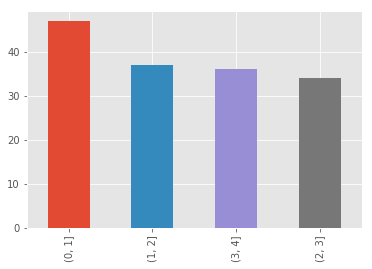

In [7]:
# rain_types.head()
bins_rain_types = pd.cut(data['RAIN'],[0,1,2,3,4])
bins_rain_types = bins_rain_types.cat.as_unordered()

bins_rain_types.value_counts().plot(kind='bar')

In [8]:
data['RAIN']=bins_rain_types
rain_dummies = pd.get_dummies(data['RAIN'], prefix='rain')

In [9]:
new_data = data[['DATE2', 'ENTRIES', 'EXITS', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'is_weekend']]
new_data = pd.concat([new_data,rain_dummies],axis=1)
new_data.rename(columns={'rain_(0, 1]':'rain_1','rain_(1, 2]':'rain_2','rain_(2, 3]':'rain_3','rain_(3, 4]':'rain_4'}, inplace=True)
new_data.head()

,DATE2,ENTRIES,EXITS,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,rain_1,rain_2,rain_3,rain_4
0,2017-12-01,30580,26633,0.00,0.0,0.0,52.0,42.0,0,0,0,0,0
1,2017-12-02,11568,10978,0.00,0.0,0.0,48.0,39.0,1,0,0,0,0
2,2017-12-03,7588,7336,0.00,0.0,0.0,48.0,42.0,1,0,0,0,0
3,2017-12-04,32905,27101,0.00,0.0,0.0,51.0,40.0,0,0,0,0,0
4,2017-12-05,32625,27968,0.75,0.0,0.0,61.0,50.0,0,0,0,0,1


In [11]:
features = ['PRCP','SNOW','SNWD','TMAX','TMIN', 'rain_1', 'rain_2']
# # import seaborn as sns
wkend_entries = new_data[new_data.is_weekend == 1]
weekday_entries = new_data[new_data.is_weekend == 0]
weekend_results = pd.DataFrame(feature_results_summary(wkend_entries))
weekday_results = pd.DataFrame(feature_results_summary(weekday_entries))
# new_data is the main dataframe at this point------MODEL FITTING BEGINS----vvvvvvv

In [57]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np 
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns


new_data.head()

,DATE2,ENTRIES,EXITS,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,rain_1,rain_2,rain_3,rain_4,PRCP^2,SNOW^2,SNWD^2,TMAX^2,TMIN^2
0,2017-12-01,30580,26633,0.00,0.0,0.0,52.0,42.0,0,0,0,0,0,0.0000,0.0,0.0,2704.0,1764.0
1,2017-12-02,11568,10978,0.00,0.0,0.0,48.0,39.0,1,0,0,0,0,0.0000,0.0,0.0,2304.0,1521.0
2,2017-12-03,7588,7336,0.00,0.0,0.0,48.0,42.0,1,0,0,0,0,0.0000,0.0,0.0,2304.0,1764.0
3,2017-12-04,32905,27101,0.00,0.0,0.0,51.0,40.0,0,0,0,0,0,0.0000,0.0,0.0,2601.0,1600.0
4,2017-12-05,32625,27968,0.75,0.0,0.0,61.0,50.0,0,0,0,0,1,0.5625,0.0,0.0,3721.0,2500.0


In [16]:
target = new_data.ENTRIES
features = new_data.iloc[:,3:]


In [20]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34,test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(292, 10) (292,)
(73, 10) (73,)


In [21]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

Text(0,0.5,'Predictions')

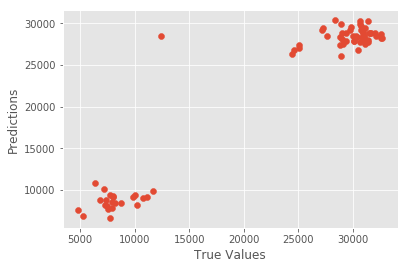

In [22]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [29]:
print ("Score:", model.score(X_test, y_test))
# so our model is highly predictive... ? I think? 

Score: 0.9231768528111041


In [27]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

2049.189688198751
8124541.048230333
2850.3580561449353


### Feature Engineering Begins ###
Going to try squaring some of the features to see if it changes above performance 

In [33]:
new_data_squared = new_data
list_to_square = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']
#helper method to square a list of columns by name 
def new_column_squared_from_list(l, df):
    for c in l: 
        c_new = c+'^2'
        df[c_new] = df[c]**2
new_column_squared_from_list(list_to_square, new_data_squared)
new_data_squared.head()


,DATE2,ENTRIES,EXITS,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,rain_1,rain_2,rain_3,rain_4,PRCP^2,SNOW^2,SNWD^2,TMAX^2,TMIN^2
0,2017-12-01,30580,26633,0.00,0.0,0.0,52.0,42.0,0,0,0,0,0,0.0000,0.0,0.0,2704.0,1764.0
1,2017-12-02,11568,10978,0.00,0.0,0.0,48.0,39.0,1,0,0,0,0,0.0000,0.0,0.0,2304.0,1521.0
2,2017-12-03,7588,7336,0.00,0.0,0.0,48.0,42.0,1,0,0,0,0,0.0000,0.0,0.0,2304.0,1764.0
3,2017-12-04,32905,27101,0.00,0.0,0.0,51.0,40.0,0,0,0,0,0,0.0000,0.0,0.0,2601.0,1600.0
4,2017-12-05,32625,27968,0.75,0.0,0.0,61.0,50.0,0,0,0,0,1,0.5625,0.0,0.0,3721.0,2500.0


In [36]:
target = new_data_squared.ENTRIES
features = new_data_squared.iloc[:,3:]

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34,test_size=0.2)
    
print ("Score:", model.score(X_test, y_test))
# improved it by .05 % so that's interesting... 

Score: 0.9285855021060158


In [37]:
#------------------------------------MORE ABOUT FEATURE SELECTION --------vvvvvvvvvvv
# using polynomial to see what we get in terms of getting rid of features

In [52]:
#using original ones because SKLearn does polynomials and gives a whole bunch. 
#will be an interesting comparison 

target = new_data.ENTRIES
features = new_data.iloc[:,3:13]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=32,test_size=0.2)


In [53]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_64_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names(X_train.columns))
features_64_train.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,rain_1,rain_2,rain_3,rain_4,...,rain_1^2,rain_1 rain_2,rain_1 rain_3,rain_1 rain_4,rain_2^2,rain_2 rain_3,rain_2 rain_4,rain_3^2,rain_3 rain_4,rain_4^2
0,0.00,0.0,0.0,70.0,54.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,91.0,73.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.03,0.0,0.0,53.0,49.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,50.0,42.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.25,0.0,0.0,66.0,51.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [54]:
features_64_test = pd.DataFrame(poly.fit_transform(X_test), columns=poly.get_feature_names(X_test.columns))
features_64_test.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,rain_1,rain_2,rain_3,rain_4,...,rain_1^2,rain_1 rain_2,rain_1 rain_3,rain_1 rain_4,rain_2^2,rain_2 rain_3,rain_2 rain_4,rain_3^2,rain_3 rain_4,rain_4^2
0,0.00,0.0,0.0,47.0,39.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.01,0.0,0.0,41.0,31.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.0,30.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,82.0,65.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.15,0.0,0.0,77.0,71.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [56]:
thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

features_selected_train = variance_threshold_selector(features_64_train)
features_selected_train.head()

,SNOW,SNWD,TMAX,TMIN,PRCP^2,PRCP TMAX,PRCP TMIN,SNOW^2,SNOW SNWD,SNOW TMAX,...,TMAX rain_1,TMAX rain_2,TMAX rain_3,TMAX rain_4,TMIN^2,TMIN is_weekend,TMIN rain_1,TMIN rain_2,TMIN rain_3,TMIN rain_4
0,0.0,0.0,70.0,54.0,0.0000,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2916.0,54.0,0.0,0.0,0.0,0.0
1,0.0,0.0,91.0,73.0,0.0000,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5329.0,73.0,0.0,0.0,0.0,0.0
2,0.0,0.0,53.0,49.0,0.0009,1.59,1.47,0.0,0.0,0.0,...,53.0,0.0,0.0,0.0,2401.0,0.0,49.0,0.0,0.0,0.0
3,0.0,0.0,50.0,42.0,0.0000,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1764.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,66.0,51.0,0.0625,16.50,12.75,0.0,0.0,0.0,...,0.0,0.0,66.0,0.0,2601.0,51.0,0.0,0.0,51.0,0.0


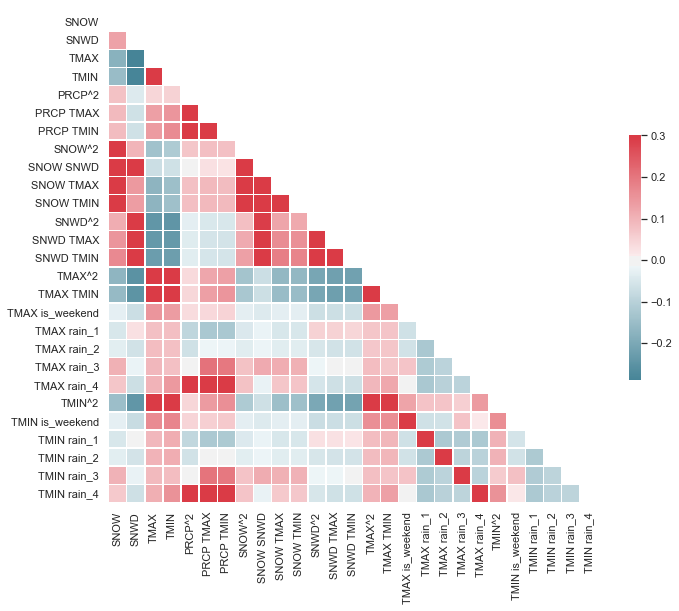

In [58]:

sns.set(style="white")

# Compute the correlation matrix
corr = features_selected_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [62]:
# upper
# to_drop

In [63]:
features_selected_train.drop(columns=to_drop, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [68]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [69]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [71]:
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(features_selected_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [72]:
features_selected_train[features_selected_train.columns[fit.get_support(indices=True)]].head()

,SNOW,SNWD,TMAX,PRCP^2,PRCP TMAX,SNOW SNWD,SNWD^2,SNWD TMAX,TMAX is_weekend,TMAX rain_1,TMAX rain_2,TMAX rain_3,TMAX rain_4
0,0.0,0.0,70.0,0.0000,0.00,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0
1,0.0,0.0,91.0,0.0000,0.00,0.0,0.0,0.0,91.0,0.0,0.0,0.0,0.0
2,0.0,0.0,53.0,0.0009,1.59,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0
3,0.0,0.0,50.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,66.0,0.0625,16.50,0.0,0.0,0.0,66.0,0.0,0.0,66.0,0.0


In [73]:
features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k='all')

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [74]:
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train, y_train)

In [75]:
features_selected_test = features_64_test[features_selected_train.columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

3700.6774759801465
21756873.6517656
4664.426401152193


In [76]:
from sklearn.feature_selection import RFE

In [77]:
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(features_selected_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [78]:
def ranking(ranks, names, order=1):

    ranks = map(lambda x: round(x,2), ranks)
    return list(sorted(zip(ranks, names),reverse=True))

In [79]:
rankings = ranking(np.abs(lm.coef_), features_selected_train.columns)

In [83]:
rankings[:15]

[(1181.79, 'SNOW'),
 (339.22, 'PRCP^2'),
 (297.28, 'TMAX is_weekend'),
 (144.87, 'SNWD^2'),
 (135.66, 'SNOW SNWD'),
 (126.97, 'TMAX'),
 (100.36, 'SNWD'),
 (27.67, 'SNWD TMAX'),
 (19.22, 'PRCP TMAX'),
 (9.5, 'TMAX rain_3'),
 (2.92, 'TMAX rain_2'),
 (0.69, 'TMAX rain_4'),
 (0.24, 'TMAX rain_1')]

In [81]:
[item[1] for item in rankings[0:15]]


['SNOW',
 'PRCP^2',
 'TMAX is_weekend',
 'SNWD^2',
 'SNOW SNWD',
 'TMAX',
 'SNWD',
 'SNWD TMAX',
 'PRCP TMAX',
 'TMAX rain_3',
 'TMAX rain_2',
 'TMAX rain_4',
 'TMAX rain_1']

In [84]:
final_columns = [item[1] for item in rankings[0:15]]


In [86]:
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train[final_columns], y_train)

In [91]:
features_selected_test = features_64_test[final_columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(lm.score(features_selected_test, y_test))  # is this right? 

3700.6774759801456
21756873.65176558
4664.426401152191
0.7687356104111204


In [ ]:
# data['PRCP'].max()
# bins = [.01, 0.08, 0.25, 0.6575, 3]
# categories = ['Mist','Light Rain','Rain', 'Heavy Rain']

# data['PRCP'].hist(bins=bins, set_xlabel = categories)
# data['PRCP'].nunique()
# # feature_plots_with_graphs(wkend_entries)
# data[data['PRCP']>0.01]['PRCP'].quantile(.75)

# data['PRCP'].quantile(0.25)
# data.ENTRIES[data.ENTRIES > 45000]